In [9]:
#This file contains illustration in the figures presented in section 5.1 in the paper 
#The code is not our newest version but since the main point here is to demonstrate 
#robustness(no time-comparison is required) all should be fine
import numpy as np
import matplotlib.pyplot as plt
import particles as pc
from scipy.stats import norm
from particles import resampling as rs
import statistics as st
#LG model
T=72
Ns=1000
theta_true=0.95
mu0=0
sigmax=0.2
sigma0=sigmax*(1-theta_true**2)**-.5
sigmay=0.5
np.random.seed(1)
X_true=[np.random.normal(mu0,sigma0)]
for t in range(T):   
    X_true.append(X_true[-1]*theta_true+np.random.normal(0,sigmax))
Y=X_true+np.random.normal(0,sigmay,T+1)
plt.plot(X_true,color='b',label='X_t')
plt.plot(Y,color='r',label='Y_t')
plt.xlabel("t")
plt.ylabel("Demonstration of robustness")
plt.ylim(-1.4,2.15) 
plt.legend()

c1=10
A=100
alpha=1
phi0=-0.1

In [10]:
#emperical
#initialisation
#phis=np.array([phi0])
phis=np.array([phi0])
np.random.seed(1)
X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
w_tem=w_tem/sum(w_tem)
#l=np.array([sum(phi0* X**2/sigmax**2)/Ns]) 
X=[X[rs.multinomial(w_tem)]]
l=np.array([0]) 
for t in range(T):
    #propagation
    a_t=c1/((t+A+1)**alpha)
    X_tem=np.random.normal(phis[-1]*X[-1],sigmax)    
    w_tem=norm(X_tem,sigmay).pdf(Y[t+1])
    X=np.append(X,[X_tem],axis=0)
    X=X[:,rs.multinomial(w_tem/sum(w_tem))]
    matsum=np.sum(X[0:t+1]*X[1:t+2])-np.sum(np.dot(phis,X[0:t+1]**2))
    l=np.append(l,matsum/Ns/sigmax**2)
    #grad=sum((X[-2]+1)*(X[-1]+1-phis[-1]*(X[-2]+1))/sigmax**2*w_tem/np.sum(w_tem))
    grad=l[-1]-l[-2]

    phis=np.append(phis,phis[-1]+a_t*grad)

plt.plot(phis)
print(phis[-1])
#100,0.55,emperical
phisstore=phis

0.6080357669367764


In [11]:
#new
k1=1
ess1=.98
ess2=1
#initialisation
#phis=np.array([phi0])
phis=np.array([phi0])
np.random.seed(0)
X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
w_tem=w_tem/sum(w_tem)
X_old=X
X=[X[rs.multinomial(w_tem)]]
w_tem=np.ones(Ns)/Ns
w_old=w_tem
for t in range(T):
    #propagation
    a_t=c1/((t+A+1)**alpha)
    X_tem=np.random.normal(phis[-1]*X[-1],sigmax)    
    w_tem*=norm(X_tem,sigmay).pdf(Y[t+1])
    X=np.append(X,[X_tem],axis=0)
    sum1=sum(np.sum(X[0:t+1]*(X[1:t+2]-phis[-1]*X[0:t+1]),axis=0)/sigmax**2*w_tem/np.sum(w_tem))
    sum2=sum(np.sum(X_old[0:t]*(X_old[1:t+1]-phis[-1]*X_old[0:t]),axis=0)*w_old/np.sum(w_old))/sigmax**2  
    grad=sum1-sum2  
    #print(t,sum1,sum2)
    #lacks term?
    phis=np.append(phis,phis[-1]+a_t*grad)
    a=np.zeros(Ns)
    #questions about phis -2, shouldn't be the last phi for generating SMC?               
    P=norm(phis[-1]*X[0:t,:],sigmax).pdf(X[1:t+1,:])/norm(phis[-2]*X[0:t,:],sigmax).pdf(X[1:t+1,:])               
    a=np.prod(P,axis=0)
    
    if(a[0]>0):
        a/=sum(a)
        cv_a=st.variance(a)/(st.mean(a)**2)
        ess_a=1/(1+cv_a)
        w_tem*=a
        cv_w=st.variance(w_tem)/(st.mean(w_tem)**2)
        ess_w=1/(1+cv_w)
    else:
        ess_a=0
    
    if(ess_a<ess1):
        k1+=1
        X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
        w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
        w_tem=w_tem/sum(w_tem)
        X=[X[rs.multinomial(w_tem)]]
        for t1 in range(t+1):
            X_tem=np.random.normal(phis[-1]*X[-1],sigmax)#bootstrap,q(xt|xt-1,yt)=f(xt|xt-1))
            X=np.append(X,[X_tem],axis=0)
            w_tem*=norm(X_tem,sigmay).pdf(Y[t1+1])
        w_tem=w_tem/sum(w_tem)
        X=X[:,rs.multinomial(w_tem)]   
        w_tem=np.ones(Ns)/Ns
    elif(ess_w<ess2):
        X=X[:,rs.multinomial(w_tem/sum(w_tem))]
        w_tem=np.ones(Ns)
    X_old=X
    w_old=w_tem
plt.plot(phis),k1
print(phis[-1])
#100,0.55,new

0.9238850991092932


Text(0, 0.5, '$\\phi_{t}$')

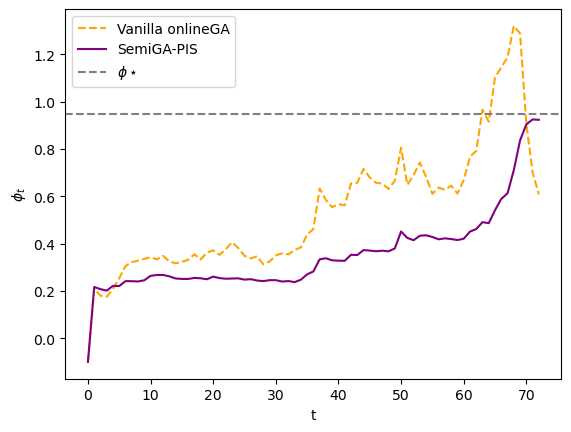

In [12]:
plt.plot(phisstore,color='orange',linestyle='dashed',label='Vanilla onlineGA')
#plt.plot(theta,loglikelihood_true,color='blue',linestyle='dashed',label='true')
plt.plot(phis,color='purple',label='SemiGA-PIS')
plt.axhline(y=0.95, color='gray', linestyle='dashed',label='$\phi\star$')
plt.legend()
plt.xlabel('t')
plt.ylabel('$\phi_{t}$')

In [16]:
lag=0
#emperical with loop
S=20
RMSE=0
F=0
for s in range(S):
    np.random.seed(s)
    phis=np.array([phi0])
    X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
    w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
    w_tem=w_tem/sum(w_tem)
    l=np.array([sum(phi0* X**2/sigmax**2)/Ns]) 
    X=[X[rs.multinomial(w_tem)]]
    l=np.array([0]) 
    for t in range(T):
        #propagation
        a_t=c1/((t+A+1)**alpha)
        X_tem=np.random.normal(phis[-1]*X[-1],sigmax)    
        w_tem=norm(X_tem,sigmay).pdf(Y[t+1])
        X=np.append(X,[X_tem],axis=0)
        X=X[:,rs.multinomial(w_tem/sum(w_tem))]
        matsum=np.sum(X[0:t+1]*X[1:t+2])-np.sum(np.dot(phis,X[0:t+1]**2))
        l=np.append(l,matsum/Ns/sigmax**2)
        #grad=sum((X[-2]+1)*(X[-1]+1-phis[-1]*(X[-2]+1))/sigmax**2*w_tem/np.sum(w_tem))
        grad=l[-1]-l[-2]
        phis=np.append(phis,phis[-1]+a_t*grad)
    #print(phis[-1])
    if(1.3>phis[-1-lag]>0.6) :
        RMSE+=(phis[-1-lag]-theta_true)**2
    else:
        RMSE+=.35**2
        F+=1
(RMSE/S)**.5,F
#F=5

    

(0.2544050294901605, 5)

In [17]:
#new
k1=1
ess1=.98
ess2=1
RMSE=0
F=0
for s in range(S):
    np.random.seed(s)

    phis=np.array([phi0])
    X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
    w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
    w_tem=w_tem/sum(w_tem)
    X_old=X
    X=[X[rs.multinomial(w_tem)]]
    w_tem=np.ones(Ns)/Ns
    w_old=w_tem
    for t in range(T):
        #propagation
        a_t=c1/((t+A+1)**alpha)
        X_tem=np.random.normal(phis[-1]*X[-1],sigmax)    
        w_tem*=norm(X_tem,sigmay).pdf(Y[t+1])
        X=np.append(X,[X_tem],axis=0)
        sum1=sum(np.sum(X[0:t+1]*(X[1:t+2]-phis[-1]*X[0:t+1]),axis=0)/sigmax**2*w_tem/np.sum(w_tem))
        sum2=sum(np.sum(X_old[0:t]*(X_old[1:t+1]-phis[-1]*X_old[0:t]),axis=0)*w_old/np.sum(w_old))/sigmax**2  
        grad=sum1-sum2  
        #print(t,sum1,sum2)
        #lacks term?
        phis=np.append(phis,phis[-1]+a_t*grad)
        a=np.zeros(Ns)
        #questions about phis -2, shouldn't be the last phi for generating SMC?               
        P=norm(phis[-1]*X[0:t,:],sigmax).pdf(X[1:t+1,:])/norm(phis[-2]*X[0:t,:],sigmax).pdf(X[1:t+1,:])               
        a=np.prod(P,axis=0)

        if(a[0]>0):
            a/=sum(a)
            cv_a=st.variance(a)/(st.mean(a)**2)
            ess_a=1/(1+cv_a)
            w_tem*=a
            cv_w=st.variance(w_tem)/(st.mean(w_tem)**2)
            ess_w=1/(1+cv_w)
        else:
            ess_a=0

        if(ess_a<ess1):
            k1+=1
            X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
            w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
            w_tem=w_tem/sum(w_tem)
            X=[X[rs.multinomial(w_tem)]]
            for t1 in range(t+1):
                X_tem=np.random.normal(phis[-1]*X[-1],sigmax)#bootstrap,q(xt|xt-1,yt)=f(xt|xt-1))
                X=np.append(X,[X_tem],axis=0)
                w_tem*=norm(X_tem,sigmay).pdf(Y[t1+1])
            w_tem=w_tem/sum(w_tem)
            X=X[:,rs.multinomial(w_tem)]   
            w_tem=np.ones(Ns)/Ns
        elif(ess_w<ess2):
            X=X[:,rs.multinomial(w_tem/sum(w_tem))]
            w_tem=np.ones(Ns)
        X_old=X
        w_old=w_tem
    #print(phis[-1],s)
    if(1.3>phis[-1-lag]>0.6):    
        RMSE+=(phis[-1-lag]-theta_true)**2
    else:
        RMSE+=0.35**2
        F+=1
(RMSE/S)**.5,F
    

    

(0.11286047198380937, 0)